# GALAH DR4 Stellar Label Optimisation


In [115]:
# Preamble
try:
    %matplotlib inline
    %config InlineBackend.figure_format='retina'
except:
    pass

import numpy as np
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from astropy.io import fits
import astropy.constants as c
import logging
import time
import astropy.units as u
from astropy.table import Table
import scipy.interpolate
from scipy import signal
from scipy.spatial import cKDTree
import scipy.optimize as op
from scipy.ndimage.filters import convolve
from scipy.io import readsav
import thecannon as tc

In [2]:
sobject_id = 160419003601116

debug = False

spectra_directory = '/Users/svenbuder/GALAH_DR4/observations/'
cannon_model_directory = '/Users/svenbuder/GALAH_DR4/spectrum_interpolation/TheCannon/models/'

# Get observation and initial parameters

In [3]:
def get_reduction_products(sobject_id, neglect_ir_beginning=True):

    """
    sobject_id: identifier for spectra
    
    neglect_ir_beginning: Cut away CCD4 information below 7700Å?

    """
    spectrum = dict()

    spectrum['sobject_id'] = sobject_id

    fits_file = fits.open(spectra_directory+str(sobject_id)[:6]+'/spectra/com/'+str(sobject_id)+'1.fits')

    spectrum['galah_id'] = fits_file[0].header['GALAH_ID']
    spectrum['tmass_id'] = fits_file[0].header['2MASS_ID']
    spectrum['gaia_edr3_source_id'] = fits_file[0].header['GAIA_ID']

    if fits_file[0].header['PAR_OK']==1:
        
        # TEFF
        spectrum['init_teff'] = fits_file[0].header['TEFF_R']
        if spectrum['init_teff'] < 3000:
            raise ValueError('TEFF < 3000')
        if spectrum['init_teff'] > 8000:
            raise ValueError('TEFF > 8000')
        
        # LOGG
        spectrum['init_logg'] = fits_file[0].header['LOGG_R']
        if spectrum['init_logg'] < -0.5:
            raise ValueError('LOGG < -0.5')
        if spectrum['init_logg'] > 5.5:
            raise ValueError('LOGG > 5.5')
            
        # FE_H
        spectrum['init_fe_h'] = fits_file[0].header['FE_H_R']
        if spectrum['init_fe_h'] < -4.0:
            raise ValueError('LOGG < -4.0')
        if spectrum['init_fe_h'] > 1.0:
            raise ValueError('LOGG > 1.0')
        
        # ALPHA_FE -> C, O, Si, Mg, Ca, Ti
        for each_alpha in ['c','o','mg','si','ca','ti']:
            spectrum['init_'+each_alpha+'_fe'] = fits_file[0].header['A_FE_R']
            if spectrum['init_'+each_alpha+'_fe'] < -1.0:
                raise ValueError('['+each_alpha+'/Fe] < -1.0')
            if spectrum['init_'+each_alpha+'_fe'] > 1.0:
                raise ValueError('['+each_alpha+'/Fe] < -1.0')
            
        # VMIC
        spectrum['init_vmic'] = fits_file[0].header['VMIC_R']
        
        # VBROAD
        spectrum['init_vsini'] = fits_file[0].header['VBROAD_R']

    else:
        raise ValueError('Reduction parameters not trustworthy!')

    if fits_file[0].header['RVCOM_OK']==1:
        spectrum['init_vrad'] = fits_file[0].header['RVCOM']
    else:
        raise ValueError('RV pipeline did not converge!')

    if fits_file[0].header['WAV_OK']==0:
        raise ValueError('Wavelength solution not ok!')

    if fits_file[0].header['CROSS_OK']==0:
        raise ValueError('Cross-talk not calculated reliably!')

    for ccd in [1,2,3,4]:

        if ccd != 1:
            fits_file = fits.open(spectra_directory+str(sobject_id)[:6]+'/spectra/com/'+str(sobject_id)+str(ccd)+'.fits')

        spectrum['crval_ccd'+str(ccd)] = fits_file[0].header['CRVAL1']
        spectrum['cdelt_ccd'+str(ccd)] = fits_file[0].header['CDELT1']

        spectrum['counts_ccd'+str(ccd)]   = fits_file[0].data
        spectrum['counts_unc_ccd'+str(ccd)] = fits_file[0].data * fits_file[2].data

        spectrum['sky_ccd'+str(ccd)]   = fits_file[3].data
        spectrum['telluric_ccd'+str(ccd)]   = fits_file[4].data

        spectrum['lsf_b_ccd'+str(ccd)] = fits_file[0].header['B']
        spectrum['lsf_ccd'+str(ccd)]   = fits_file[7].data

        fits_file.close()

        if (ccd == 4) & neglect_ir_beginning:
            wave_ccd4 = spectrum['crval_ccd4'] + spectrum['cdelt_ccd4'] * np.arange(len(spectrum['counts_ccd4']))
            bad_ir = wave_ccd4 > 7700
            spectrum['crval_ccd4'] = wave_ccd4[bad_ir][0]
            spectrum['counts_ccd4'] = spectrum['counts_ccd4'][bad_ir]
            spectrum['counts_unc_ccd4'] = spectrum['counts_unc_ccd4'][bad_ir]
            spectrum['lsf_ccd4'] = spectrum['lsf_ccd4'][bad_ir]

    return(spectrum)

spectrum = get_reduction_products(sobject_id)

In [4]:
def degrade_spectrum(wavelength_synthetic, spectrum_observed_all_ccds):
    print('We are currently looping through segments and have a buffer of +- 1 Aangstroem!')
    for each_wavelength_segment in self.wavelength_segments:
        in_segment = (
            (wavelength_synthetic >= each_wavelength_segment[0] - 1) & 
            (wavelength_synthetic <= each_wavelength_segment[-1] + 1)
        )

        smallest_dispersion_in_segment = np.min(self.wavelength_synthetic[in_segment][1:]-self.wavelength_synthetic[in_segment][:-1])
        # Now let's degrade the resolution to the one of the observation for each wavelength segment
        wavelength_synthetic_equidistant_in_segment = np.arange(self.wavelength_synthetic[in_segment][0],self.wavelength_synthetic[in_segment][-1],smallest_dispersion_in_segment)

        # Let's interpolate onto the 
        flux_synthetic_equidistant_in_segment = cubic_spline_interpolate(
            wavelength_synthetic, 
            flux_synthetic, 
            wavelength_synthetic_equidistant_in_segment
        )

        # which ccd is the segment in?
        ccd = '1'
        if flux_synthetic_equidistant_in_segment[0] > 5000:
            ccd = '2'
            if flux_synthetic_equidistant_in_segment[0] > 6000:
                ccd = '3'
                if flux_synthetic_equidistant_in_segment[0] > 7000:
                    ccd = '4'

        wavelength_synthetic_r_degraded, flux_synthetic_r_degraded = synth_resolution_degradation(
            l = spectrum_observed_all_ccds[ccd].wavelength_observed, 
            res_map = spectrum_observed_all_ccds[ccd].resolution_map, 
            res_b = spectrum_observed_all_ccds[ccd].res_b, 
            synth = np.array([wavelength_synthetic_equidistant_in_segment, flux_synthetic_equidistant_in_segment]).T,
            synth_res=300000.0)


        print(flux_synthetic_equidistant_in_segment)

In [5]:
def galah_kern(fwhm, b):
    """ Returns a normalized 1D kernel as is used for GALAH resolution profile """
    size=2*(fwhm/2.355)**2
    size_grid = int(size) # we limit the size of kernel, so it is as small as possible (or minimal size) for faster calculations
    if size_grid<7: size_grid=7
    x= scipy.mgrid[-size_grid:size_grid+1]
    g = scipy.exp(-0.693147*np.power(abs(2*x/fwhm), b))
    return g / np.sum(g)

In [6]:
def synth_resolution_degradation(l, res_map, res_b, synth, synth_res=300000.0):
    """
    Take a synthetic spectrum with a very high  resolution and degrade its resolution to the resolution profile of the observed spectrum. The synthetic spectrum should not be undersampled, or the result of the convolution might be wrong.
    Parameters:
        synth np array or similar: an array representing the synthetic spectrum. Must have size m x 2. First column is the wavelength array, second column is the flux array. Resolution of the synthetic spectrum must be constant and higher than that of the observed spectrum.
        synth_res (float): resolving power of the synthetic spectrum
    Returns:
        Convolved syntehtic spectrum as a np array of size m x 2.
    """

    synth=np.array(synth)
    l_original=synth[:,0]
    #check if the shape of the synthetic spectrum is correct
    if synth.shape[1]!=2: logging.error('Syntehtic spectrum must have shape m x 2.')

    #check if the resolving power is high enough
    sigma_synth=synth[:,0]/synth_res
    if max(sigma_synth)>=min(res_map)*0.95: logging.error('Resolving power of the synthetic spectrum must be higher.')
        
    #check if wavelength calibration of the synthetic spectrum is linear:
    if not (synth[:,0][1]-synth[:,0][0])==(synth[:,0][-1]-synth[:,0][-2]):
        logging.error('Synthetic spectrum must have linear (equidistant) sampling.')		

    #current sampling:
    sampl=synth[:,0][1]-synth[:,0][0]
    galah_sampl=l[1]-l[0]

    #original sigma
    s_original=sigma_synth

    #required sigma (resample the resolution map into the wavelength range of the synthetic spectrum)
    s_out=np.interp(synth[:,0], l, res_map)

    #the sigma of the kernel is:
    s=np.sqrt(s_out**2-s_original**2)

    #fit it with the polynomial, so we have a function instead of sampled values:
    map_fit=np.poly1d(np.polyfit(synth[:,0], s, deg=6))

    #create an array with new sampling. The first point is the same as in the spectrum:
    l_new=[synth[:,0][0]]

    #oversampling. If synthetic spectrum sampling is much finer than the size of the kernel, the code would work, but would return badly sampled spectrum. this is because from here on the needed sampling is measured in units of sigma.
    oversample=galah_sampl/sampl*5.0

    #minimal needed sampling
    min_sampl=max(s_original)/sampl/sampl*oversample

    #keep adding samples until end of the wavelength range is reached
    while l_new[-1]<synth[:,0][-1]+sampl:
        l_new.append(l_new[-1]+map_fit(l_new[-1])/sampl/min_sampl)

    #interpolate the spectrum to the new sampling:
    new_f=np.interp(np.array(l_new),synth[:,0],synth[:,1])

    kernel_=galah_kern(max(s_original)/sampl*oversample, res_b)

    con_f=signal.fftconvolve(new_f,kernel_,mode='same')

    #inverse the warping:
    synth[:,1]=np.interp(l_original,np.array(l_new),con_f)
    return synth.T

In [7]:
def cubic_spline_interpolate(old_wavelength, old_flux, new_wavelength):
    """
    INPUT:
    old_wavelength, old_flux: Input spectrum that has to be interpolated
    new_wavelength: Wavelength array onto which we want to interpolate
    
    OUTPUT:
    flux interpolated on new_wavelength array
    """
    return scipy.interpolate.CubicSpline(old_wavelength, old_flux)(new_wavelength)

In [8]:
def gaussbroad(w, s, hwhm):
    """
    Smooths a spectrum by convolution with a gaussian of specified hwhm.
    Parameters
    -------
    w : array[n]
        wavelength scale of spectrum to be smoothed
    s : array[n]
        spectrum to be smoothed
    hwhm : float
        half width at half maximum of smoothing gaussian.
    Returns
    -------
    sout: array[n]
        the gaussian-smoothed spectrum.
    """
    """
    History
    --------
        Dec-90 GB,GM
            Rewrote with fourier convolution algorithm.
        Jul-91 AL
            Translated from ANA to IDL.
        22-Sep-91 JAV
            Relaxed constant dispersion check# vectorized, 50% faster.
        05-Jul-92 JAV
            Converted to function, handle nonpositive hwhm.
        Oct-18 AW
            Python version
    """

    # Warn user if hwhm is negative.
    if hwhm < 0:
        logger.warning("Forcing negative smoothing width to zero.")

    # Return input argument if half-width is nonpositive.
    if hwhm <= 0:
        return s  # true: no broadening

    # Calculate (uniform) dispersion.
    nw = len(w)  ## points in spectrum
    wrange = w[-1] - w[0]
    dw = wrange / (nw - 1)  # wavelength change per pixel

    # Make smoothing gaussian# extend to 4 sigma.
    # 4.0 / sqrt(2.0*alog(2.0)) = 3.3972872 and sqrt(alog(2.0))=0.83255461
    # sqrt(alog(2.0)/pi)=0.46971864 (*1.0000632 to correct for >4 sigma wings)
    if hwhm >= 5 * wrange:
        return np.full(nw, np.sum(s) / nw)
    nhalf = int(3.3972872 * hwhm / dw)  ## points in half gaussian
    ng = 2 * nhalf + 1  ## points in gaussian (odd!)
    wg = dw * (
        np.arange(ng, dtype=float) - (ng - 1) / 2
    )  # wavelength scale of gaussian
    xg = (0.83255461 / hwhm) * wg  # convenient absisca
    gpro = (0.46974832 * dw / hwhm) * np.exp(-xg * xg)  # unit area gaussian w/ FWHM
    gpro = gpro / np.sum(gpro)

    # Pad spectrum ends to minimize impact of Fourier ringing.
    sout = convolve(s, gpro, mode="nearest")

    return sout

In [9]:
def apply_gauss_broad(wave, smod, ipres=30000, debug=True):
    # Apply Gaussian Instrument Broadening
    if ipres == 0.0:
        hwhm = 0
    else:
        hwhm = 0.5 * wave[0] / ipres
    if hwhm > 0: smod = gaussbroad(wave, smod, hwhm)

    return(smod)

In [10]:
def sclip(p,fit,n,ye=[],sl=99999,su=99999,min=0,max=0,min_data=1,grow=0,global_mask=None,verbose=True):
    """
    p: array of coordinate vectors. Last line in the array must be values that are fitted. The rest are coordinates.
    fit: name of the fitting function. It must have arguments x,y,ye,and mask and return an array of values of the fitted function at coordinates x
    n: number of iterations
    ye: array of errors for each point
    sl: lower limit in sigma units
    su: upper limit in sigma units
    min: number or fraction of rejected points below the fitted curve
    max: number or fraction of rejected points above the fitted curve
    min_data: minimal number of points that can still be used to make a constrained fit
    global_mask: if initial mask is given it will be used throughout the whole fitting process, but the final fit will be evaluated also in the masked points
    grow: number of points to reject around the rejected point.
    verbose: print the results or not
    """

    nv,dim=np.shape(p)

    #if error vector is not given, assume errors are equal to 0:
    if ye==[]: ye=np.zeros(dim)
    #if a single number is given for y errors, assume it means the same error is for all points:
    if isinstance(ye, (int, float)): ye=np.ones(dim)*ye

    if global_mask==None: global_mask=np.ones(dim, dtype=bool)
    else: pass

    f_initial=fit(p,ye,global_mask)
    s_initial=np.std(p[-1]-f_initial)

    f=f_initial
    s=s_initial

    tmp_results=[]

    b_old=np.ones(dim, dtype=bool)

    for step in range(n):
        #check that only sigmas or only min/max are given:
        if (sl!=99999 or su!=99999) and (min!=0 or max!=0):
            raise RuntimeError('Sigmas and min/max are given. Only one can be used.')

        #if sigmas are given:
        if sl!=99999 or su!=99999:
            b=np.zeros(dim, dtype=bool)
            if sl>=99999 and su!=sl: sl=su#check if only one is given. In this case set the other to the same value
            if su>=99999 and sl!=su: su=sl

            good_values=np.where(((f-p[-1])<(sl*(s+ye))) & ((f-p[-1])>-(su*(s+ye))))#find points that pass the sigma test
            b[good_values]=True

        #if min/max are given
        if min!=0 or max!=0:
            b=np.ones(dim, dtype=bool)
            if min<1: min=dim*min#detect if min is in number of points or percentage
            if max<1: max=dim*max#detect if max is in number of points or percentage

            bad_values=np.concatenate(((p[-1]-f).argsort()[-int(max):], (p[-1]-f).argsort()[:int(min)]))
            b[bad_values]=False

        #check the grow parameter:
        if grow>=1 and nv==2:
            b_grown=np.ones(dim, dtype=bool)
            for ind,val in enumerate(b):
                if val==False:
                    ind_l=ind-int(grow)
                    ind_u=ind+int(grow)+1
                    if ind_l<0: ind_l=0
                    b_grown[ind_l:ind_u]=False

            b=b_grown

        tmp_results.append(f)

        #check that the minimal number of good points is not too low:
        if len(b[b])<min_data:
            step=step-1
            b=b_old
            break

        #check if the new b is the same as old one and break if yes:
        if np.array_equal(b,b_old):
            step=step-1
            break

        #fit again
        f=fit(p,ye,b&global_mask)
        s=np.std(p[-1][b]-f[b])
        b_old=b

    if verbose:
        print('')
        print('FITTING RESULTS:')
        print('Number of iterations requested:    ',n)
        print('Number of iterations performed:    ', step+1)
        print('Initial standard deviation:        ', s_initial)
        print('Final standard deviation:          ', s)
        print('Number of rejected points:         ',len(np.invert(b[np.invert(b)])))
        print('')

    return f,tmp_results,b

In [11]:
def chebyshev(p,ye,mask):
    coef=np.polynomial.chebyshev.chebfit(p[0][mask], p[1][mask], 4)
    cont=np.polynomial.chebyshev.chebval(p[0],coef)
    return cont

In [12]:
def rv_shift(rv_value, wavelength):
    '''
    Shifts observed wavelengths to account for radial velocity measurements
    
    INPUT:
    rv_value = radial velocity in km/s (negative if moving towards earth)
    wavelengths = array of observed wavelengths
    
    OUTPUT:
    array of shifted wavelengths
    '''
    return wavelength / (1.+rv_value/c.c.to(u.km/u.s).value)

In [13]:
cannon_models = Table.read('../spectrum_interpolation/TheCannon/Cannon_subgrid.fits')
cannon_index_tree = cKDTree(np.c_[cannon_models['teff'],cannon_models['logg'],cannon_models['fe_h']])

def find_closest_cannon_model(cannon_index_tree, teff, logg, feh, labels, order, debug=True):

    cannon_index = cannon_index_tree.query(np.c_[teff, logg, feh])[1]
    
    if debug:
        print(cannon_index)
        print('input: ',teff,logg,feh)
        print('Cannon: ',cannon_models['teff'][cannon_index][0],cannon_models['logg'][cannon_index][0],cannon_models['fe_h'][cannon_index][0])

    model_file = 'subgrid_'+str(cannon_models['index'][cannon_index][0])+'_order'+str(order)+'_'+str(len(labels))+'labels'
    if debug:
        print(model_file)
    
    return(model_file)

In [25]:
def create_synthetic_spectrum(labels, debug=True):
    
    teff, logg, fe_h, = labels
    
    model_file = find_closest_cannon_model(cannon_index_tree, teff, logg, fe_h, labels=labels, order=2, debug=debug)
    model = tc.CannonModel.read('../spectrum_interpolation/TheCannon/models/'+model_file+'.model')
    
    model_spectrum = model.__call__([teff, logg, fe_h])
    return(model.dispersion, model_spectrum, model.s2)

In [117]:
def match_observation_and_model(model_parameters, spectrum, masks, debug=True):
    
    # modelling parameters to estimate
    vrad, teff, logg, fe_h = model_parameters
        
    # use model parameters to get a model spectrum
    wave_model, flux_model, s2_model = create_synthetic_spectrum([teff, logg, fe_h], debug)
    
    # at the moment, let's assume cdelt and crval are correct
    
    for ccd in [1,2,3,4]:
        
        spectrum['wave_ccd'+str(ccd)] = rv_shift(vrad,spectrum['crval_ccd'+str(ccd)] + spectrum['cdelt_ccd'+str(ccd)]*np.arange(len(spectrum['counts_ccd'+str(ccd)])))
        
        # Prepare degrading synthetic spectrum by interpolating onto equidistant grid
        wave_model_ccd = (wave_model > (3+ccd)*1000) & (wave_model < (4+ccd)*1000)
        smallest_dispersion_in_segment = np.min(wave_model[wave_model_ccd][1:]-wave_model[wave_model_ccd][:-1])
        wave_model_equidistant = np.arange(wave_model[wave_model_ccd][0],wave_model[wave_model_ccd][-1],smallest_dispersion_in_segment)
        flux_model_equidistant = cubic_spline_interpolate(
            wave_model[wave_model_ccd], 
            flux_model[wave_model_ccd], 
            wave_model_equidistant
        )
        s2_model_equidistant = cubic_spline_interpolate(
            wave_model[wave_model_ccd], 
            s2_model[wave_model_ccd], 
            wave_model_equidistant
        )
        # Degrade synthetic spectrum onto LSF
        wave_model_ccd_lsf, flux_model_ccd_lsf = synth_resolution_degradation(
            l = spectrum['crval_ccd1'] + spectrum['cdelt_ccd1']*np.arange(len(spectrum['counts_ccd1'])), 
            res_map = spectrum['lsf_ccd1'], 
            res_b = spectrum['lsf_b_ccd1'], 
            synth = np.array([wave_model_equidistant, flux_model_equidistant]).T,
            synth_res=1000000.0)

        wave_model_ccd_lsf, s2_model_ccd_lsf = synth_resolution_degradation(
            l = spectrum['crval_ccd1'] + spectrum['cdelt_ccd1']*np.arange(len(spectrum['counts_ccd1'])), 
            res_map = spectrum['lsf_ccd1'], 
            res_b = spectrum['lsf_b_ccd1'], 
            synth = np.array([wave_model_equidistant, s2_model_equidistant]).T,
            synth_res=1000000.0)
        
        # Interpolate model onto right wavelength grid
        spectrum['flux_model_ccd'+str(ccd)] = cubic_spline_interpolate(
            wave_model_ccd_lsf,
            flux_model_ccd_lsf,
            spectrum['wave_ccd'+str(ccd)]
        )
        spectrum['s2_model_ccd'+str(ccd)] = cubic_spline_interpolate(
            wave_model_ccd_lsf,
            s2_model_ccd_lsf,
            spectrum['wave_ccd'+str(ccd)]
        )

        renormalisation_fit = sclip((spectrum['wave_ccd'+str(ccd)],spectrum['counts_ccd'+str(ccd)]/spectrum['flux_model_ccd'+str(ccd)]),chebyshev,int(3),ye=spectrum['counts_unc_ccd'+str(ccd)],su=5,sl=5,min_data=100,verbose=False)
        spectrum['flux_obs_ccd'+str(ccd)] = spectrum['counts_ccd'+str(ccd)]/renormalisation_fit[0]
        spectrum['flux_obs_unc_ccd'+str(ccd)] = spectrum['counts_unc_ccd'+str(ccd)]/renormalisation_fit[0]
        
        if debug:
            plt.figure(figsize=(15,3))
            plt.plot(spectrum['wave_ccd'+str(ccd)],spectrum['flux_obs_ccd'+str(ccd)],c='k',label='Observation',lw=0.5)
            plt.plot(spectrum['wave_ccd'+str(ccd)],spectrum['flux_model_ccd'+str(ccd)],c='C0',label='Synthesis',lw=0.5)
            plt.plot(spectrum['wave_ccd'+str(ccd)],spectrum['flux_obs_ccd'+str(ccd)]-spectrum['flux_model_ccd'+str(ccd)],c='C1',label='Residuals',lw=0.5)
            for (mask_beginning, mask_end) in masks:
                if (mask_beginning > spectrum['wave_ccd'+str(ccd)][0]) & (mask_end < spectrum['wave_ccd'+str(ccd)][-1]):
                    plt.axvspan(mask_beginning,mask_end,color='grey',alpha=0.5)
            plt.xlabel('Wavelength [$\text{\AA}$]')
            plt.ylabel('Flux [norm.]')
            plt.ylim(-0.2,1.2)
            
    # calculate the log likelihood
    # -0.5 * sum((data-model))**2/sigma2) + log(sigma2)
    wave = np.concatenate([spectrum['wave_ccd'+str(ccd)] for ccd in [1,2,3,4]])
    
    data = np.concatenate([spectrum['flux_obs_ccd'+str(ccd)] for ccd in [1,2,3,4]])
    sigma2 = np.concatenate([spectrum['flux_obs_unc_ccd'+str(ccd)] for ccd in [1,2,3,4]])**2
    
    model = np.concatenate([spectrum['flux_model_ccd'+str(ccd)] for ccd in [1,2,3,4]])
    s2 = np.concatenate([spectrum['s2_model_ccd'+str(ccd)] for ccd in [1,2,3,4]])

    return(wave,data,sigma2,model,s2)

# Likelihood, Prior, Posterior

In [110]:
def log_likelihood(model_parameters, spectrum, masks, debug=True):
    """
    INPUT:
    model_parameters: an array with each parameter that we need to create an array "flux_modelled"
    wavelength_observed, flux_observed, flux_error_observed
    
    OUTPUT:
    log(Likelihood) = -0.5 * sum((data-model))**2/sigma2) + log(sigma2)
    """
    
    (wave,data,sigma2,model,s2) = match_observation_and_model(model_parameters, spectrum, masks, debug)
    
    # you can also add "debug" keywords. They come in handy, when debugging code.
    # Here I simply test, how rv_value is changing during the likelihood maximisation
    if debug:
        print('Current LogP Values:', model_parameters)

    unmasked = ~np.any(np.array([((wave >= mask_beginning) & (wave <= mask_end)) for (mask_beginning, mask_end) in masks]),axis=0)

    combined_sigma2 = sigma2 + s2
    
    return -0.5 * np.sum((data[unmasked] - model[unmasked]) ** 2 / combined_sigma2[unmasked] + np.log(combined_sigma2[unmasked]))

In [102]:
def log_prior(model_parameters):
    vrad, teff, logg, fe_h = model_parameters
    if teff >= 3000 and teff <= 8000 and logg >= -0.5 and logg <= 5.5 and fe_h <= 1.0:
        return 0.0
    return -np.inf

In [103]:
def log_probability(model_parameters, spectrum, masks, debug=True):
    lp = log_prior(model_parameters)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(model_parameters, spectrum, masks, debug)

# Optimisation

In [104]:
negative_log_probability_function = lambda *args: -log_probability(*args)

initial_model_parameters = [spectrum['init_vrad'],spectrum['init_teff'],spectrum['init_logg'],spectrum['init_fe_h']]
masks = np.array([[4861.3230-0.75,4861.3230+0.75],[6562.7970-1.25,6562.7970+1.25],[7500,7670]])

In [105]:
# minimization_output = op.minimize(
#     negative_log_probability_function,
#     initial_model_parameters,
#     args=(spectrum, masks, False)
# )

In [106]:
# log_likelihood(minimization_output.x, spectrum, masks, debug=True)

In [107]:
# minimization_output_one = minimization_output
# log_likelihood(minimization_output_one.x, spectrum, masks, debug=True)

In [118]:
def fit_leastsq(initial_model_parameters, spectrum, masks, debug=False):

    def residuals_for_leastsq(parameters):

        (wave,data,sigma2,model,s2) = match_observation_and_model(parameters, spectrum, masks, debug=False)
        masked = np.any(np.array([((wave >= mask_beginning) & (wave <= mask_end)) for (mask_beginning, mask_end) in masks]),axis=0)
        
        adjusted_sigma = sigma2 + s2
        adjusted_sigma[masked] = 100000.
        
        return (model - data)/np.sqrt(adjusted_sigma)
    
    kwds = {
            "func": residuals_for_leastsq,
            "Dfun": None,
            "col_deriv": True,

            # These get passed through to leastsq:
            "ftol": 7./3 - 4./3 - 1, # Machine precision.
            "xtol": 7./3 - 4./3 - 1, # Machine precision.
            "gtol": 0.0,
            "maxfev": 100000, # MAGIC
            "epsfcn": None,
            "factor": 1.0,
        }

    op_labels, cov, meta, mesg, ier = op.leastsq(
        x0 = initial_model_parameters,
        full_output=True,**kwds
    )
    
    return(op_labels, cov, meta, mesg, ier)

start_time = time.time()
op_labels, cov, meta, mesg, ier = fit_leastsq(initial_model_parameters, spectrum, masks, debug=False)
print(time.time() - start_time)
# 31s for 47 calls

31.078771829605103


[1744]
input:  5985.409344893585 4.503888397762048 0.0257491769006203
Cannon:  6000.0 4.5 0.0
subgrid_1744_order2_3labels
Current LogP Values: [-1.52170193e+01  5.98540934e+03  4.50388840e+00  2.57491769e-02]


34833.17446643769

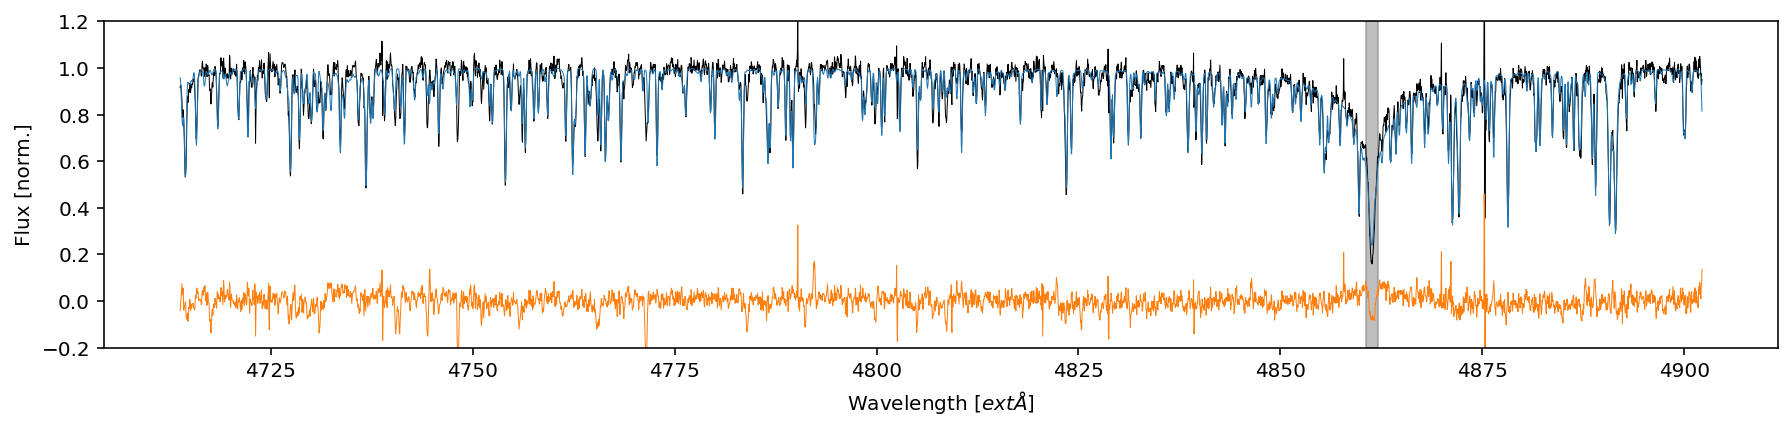

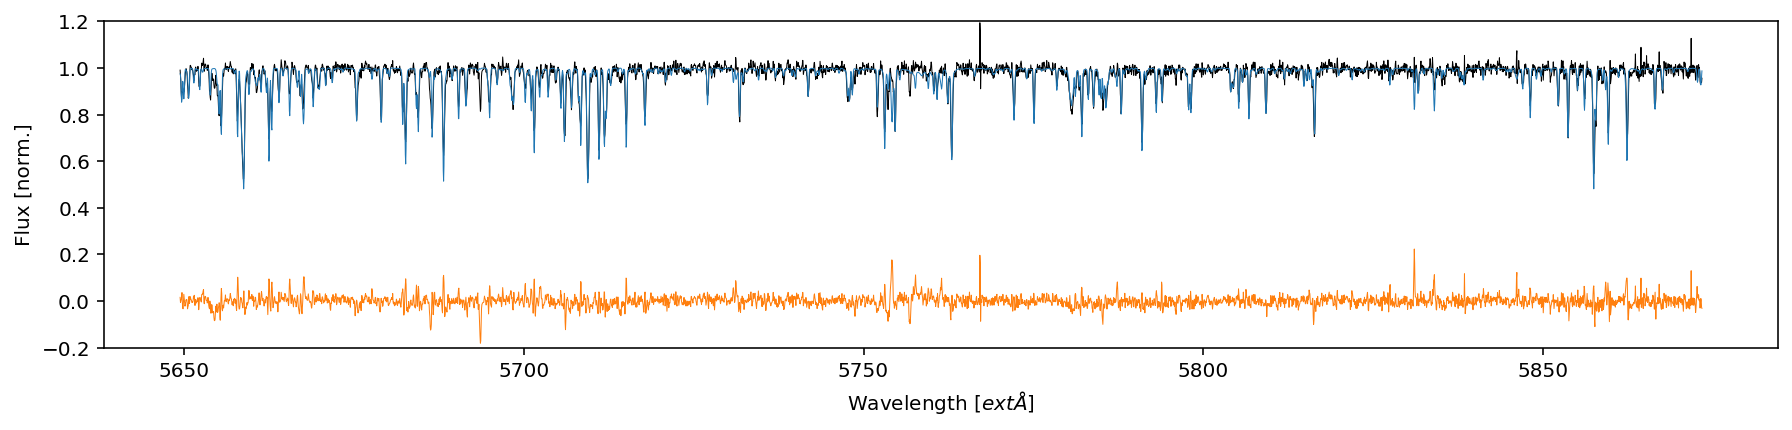

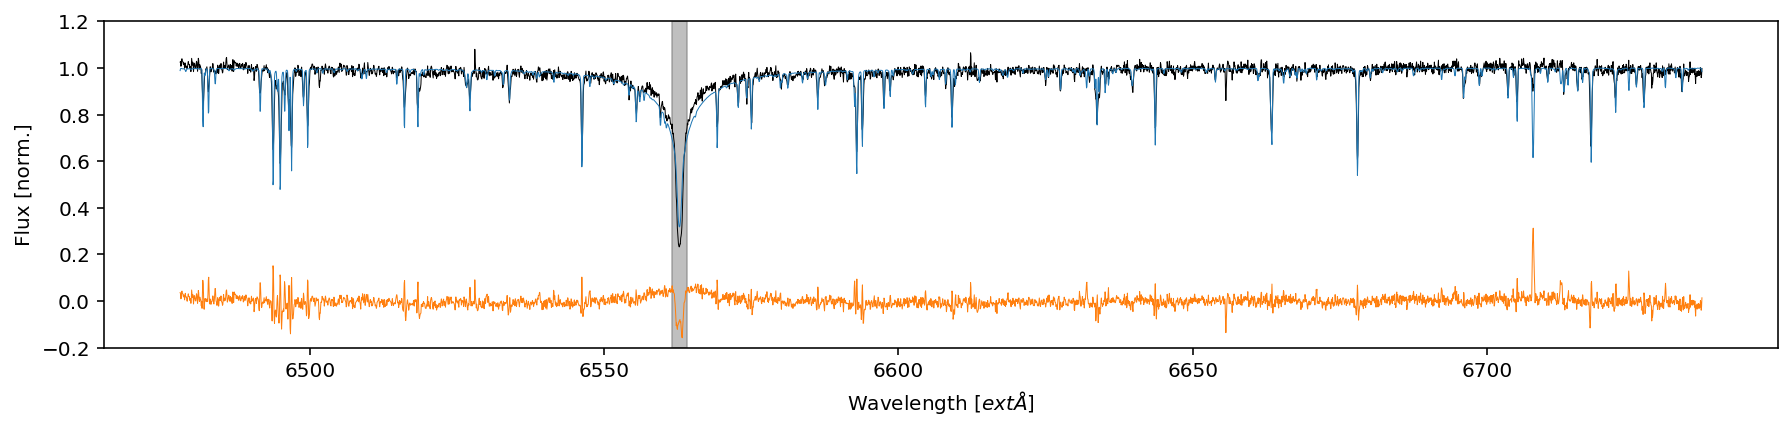

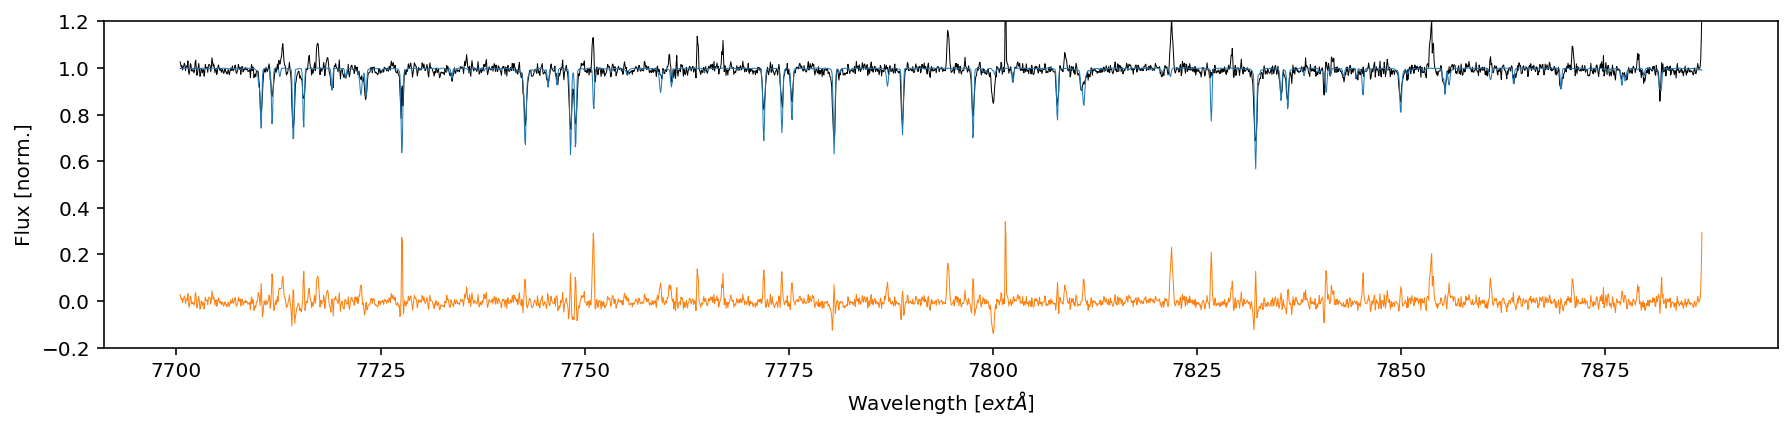

In [125]:
log_likelihood(op_labels, spectrum, masks, debug=True)

[-1.52320397e+01  5.98365635e+03  4.49603657e+00  2.36315526e-02]
[1744]
input:  5983.656345607101 4.496036567389584 0.0236315525750437
Cannon:  6000.0 4.5 0.0
subgrid_1744_order2_3labels
Current LogP Values: [-1.52320397e+01  5.98365635e+03  4.49603657e+00  2.36315526e-02]


array([   1.89576443,    3.30586534,    3.82609031, ...,    0.45255905,
        -25.58443585, -107.50757489])

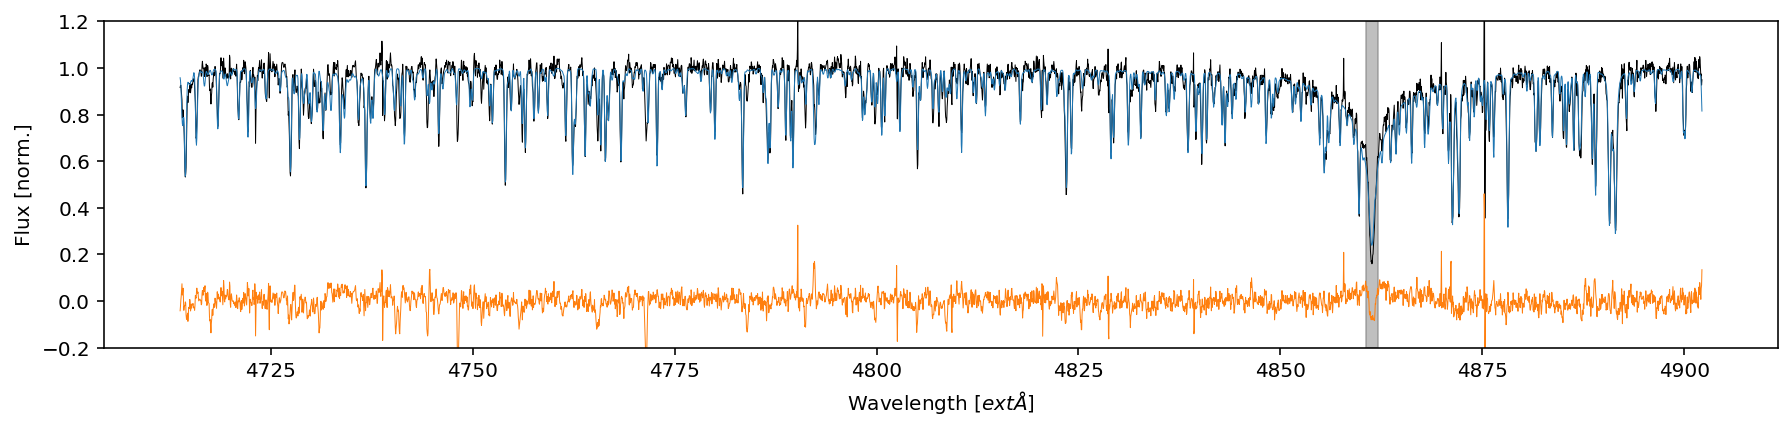

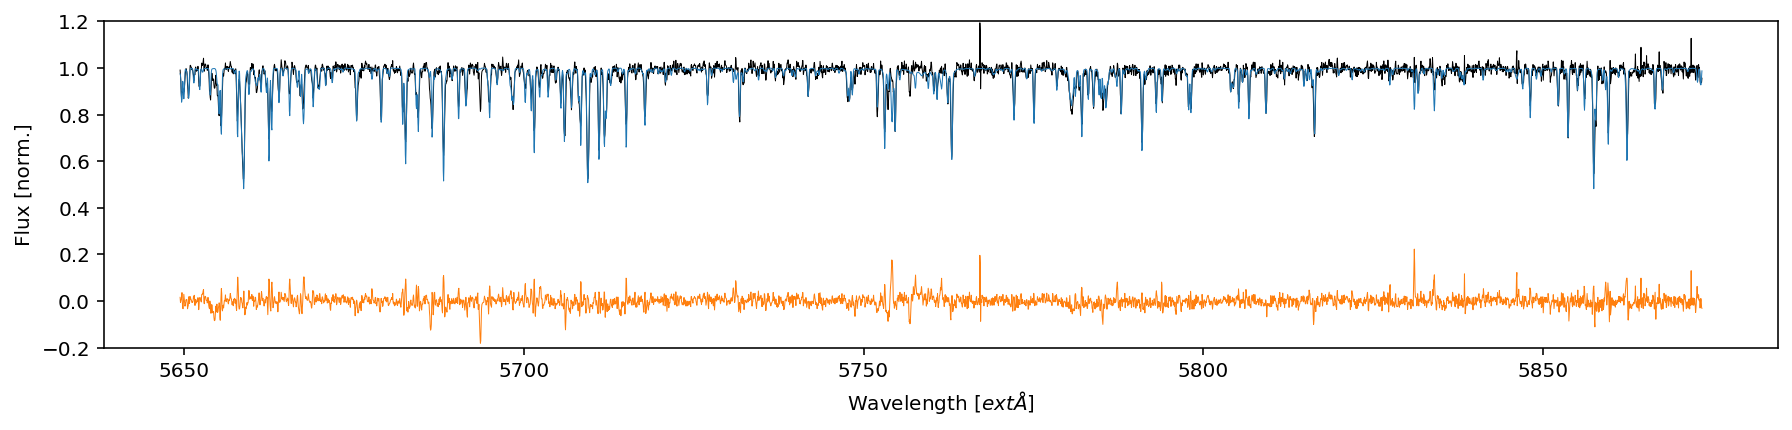

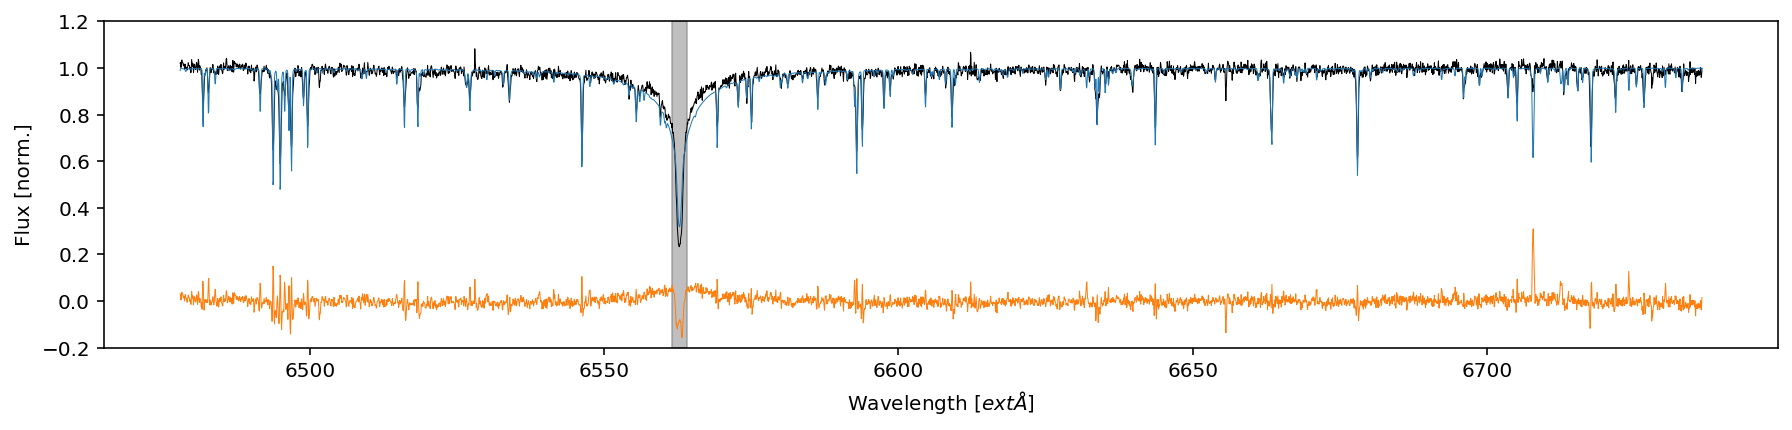

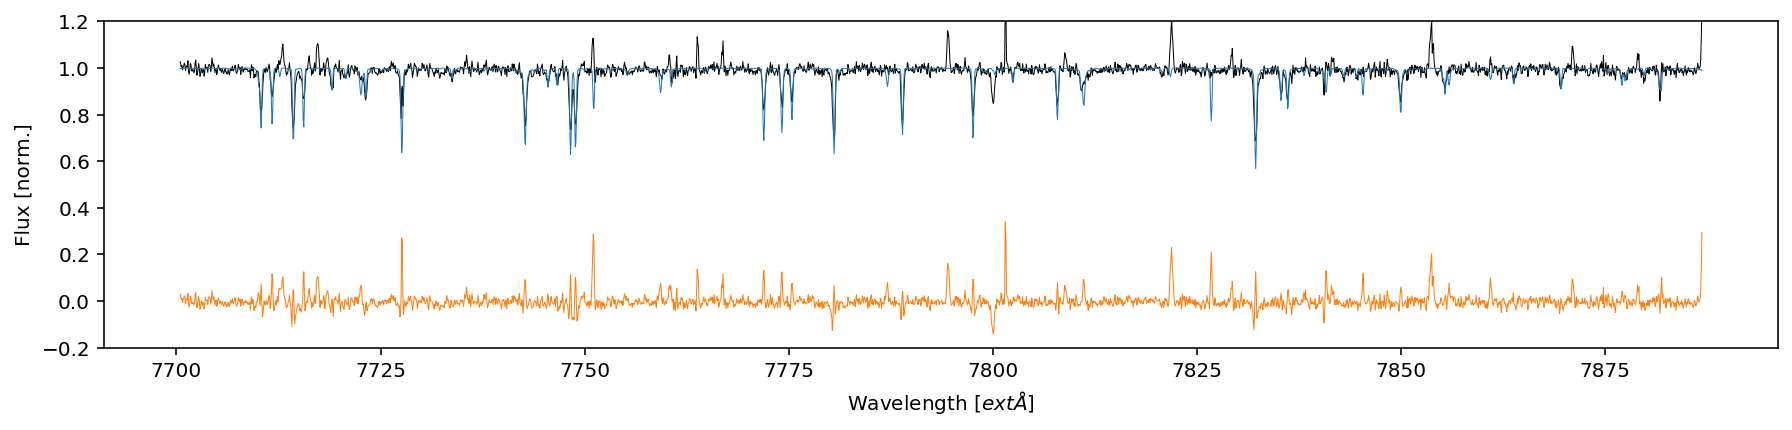

In [99]:
log_likelihood(op_labels, spectrum, masks, debug=True)

[1672]
input:  5724.015625 4.427106380462646 0.02887925505638123
Cannon:  5750.0 4.5 0.0
subgrid_1672_order2_3labels
Current LogP Values: [-15.02467464958233, 5724.015625, 4.427106380462646, 0.02887925505638123]


29593.340768350554

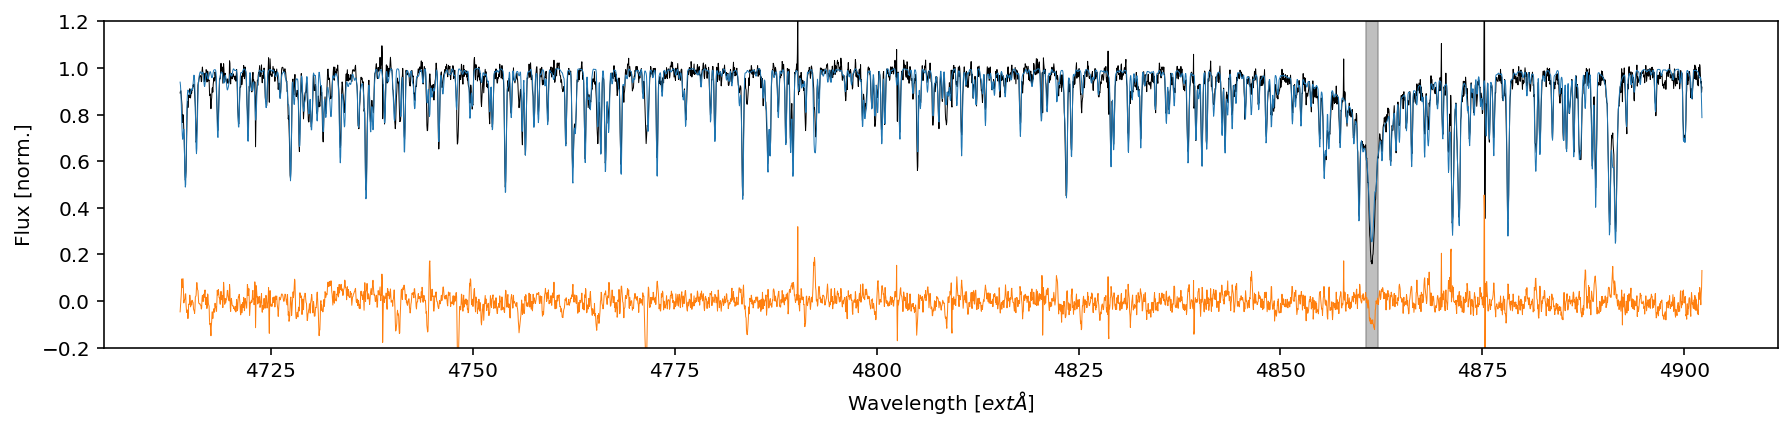

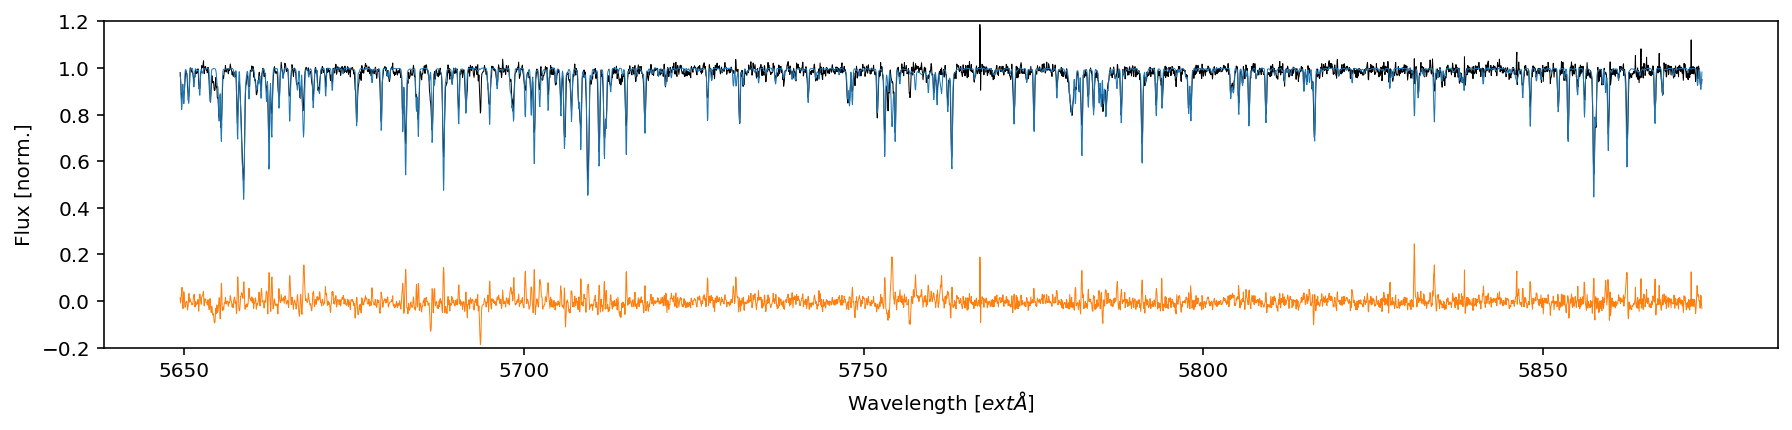

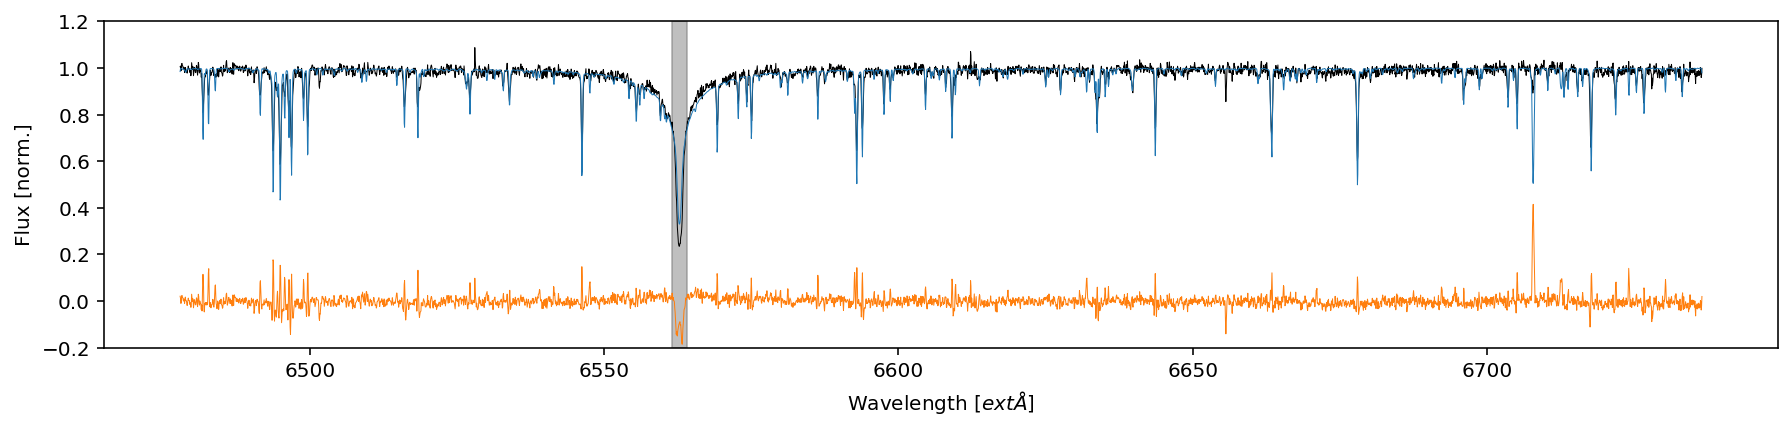

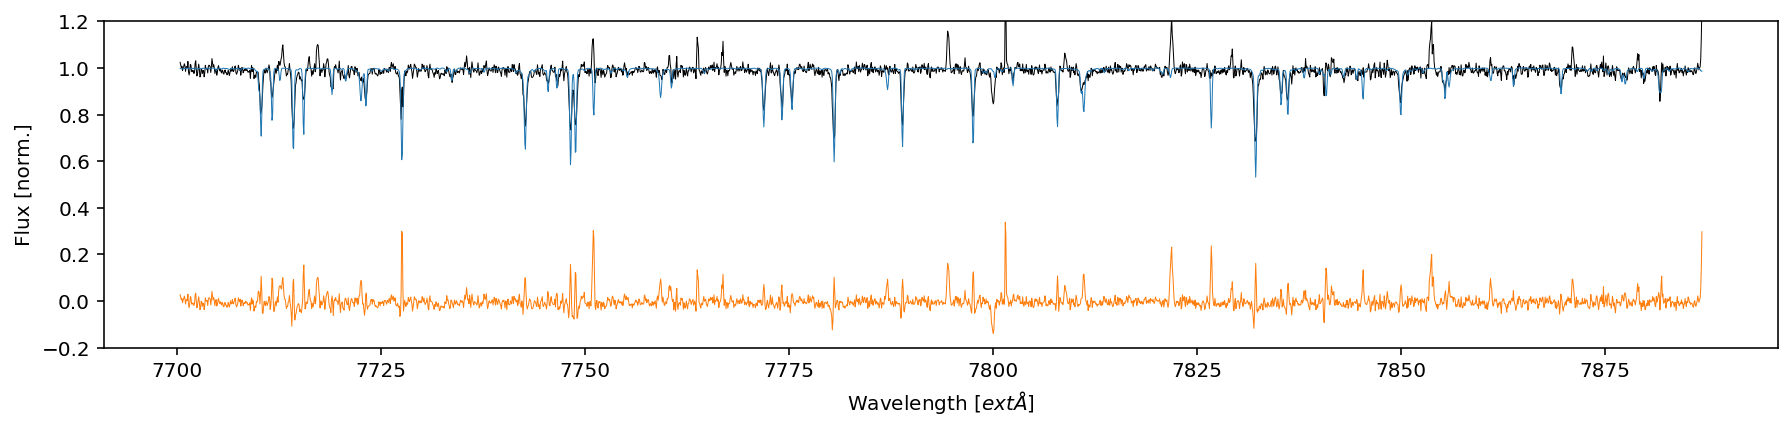

In [45]:
log_likelihood(initial_model_parameters, spectrum, masks, debug=True)